In [219]:
# %load_ext cudf.pandas
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

In [100]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# TODO: delete this
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')



In [ ]:
target_labels = ['None','Mild','Moderate','Severe']


In [126]:
columns_not_in_test = set(train_df.columns) - set(test_df.columns)
columns_not_in_test

{'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_Total',
 'PCIAT-Season',
 'sii'}

In [194]:
train_df['sii'].isnull().sum()/len(train_df)

np.float64(0.3090909090909091)

The test set does not have any of the PCIAT data, and we're missing about 30% of the `sii` label in the training data. 

In [225]:
pciat_aggs = train_df.groupby('sii')['PCIAT-PCIAT_Total'].agg(['min', 'max', 'mean'])
pciat_aggs = pciat_aggs.rename(
    columns={'min': 'Minimum PCIAT total Score', 'max': 'Maximum total PCIAT Score', 'mean': 'Average total PCIAT Score'}
)
pciat_aggs

,Minimum PCIAT total Score,Maximum total PCIAT Score,Average total PCIAT Score
sii,,,
0.0,0.0,30.0,13.929737
1.0,31.0,49.0,38.726027
2.0,50.0,79.0,60.658730
3.0,80.0,93.0,85.911765


In [224]:
# supervised_usable = train[train['sii'].notnull()]
# missing_count = supervised_usable.isnull().sum().reset_index()
# missing_count.columns = ['feature', 'null_count']
# missing_count = missing_count.sort_values(by='null_count', ascending=False)
# missing_count['null_ratio'] = missing_count['null_count'] / len(supervised_usable)

# plt.style.use('seaborn-v0_8')
# plt.figure(figsize=(6, 15))
# plt.title(f'Missing values sampled from the {len(supervised_usable)} samples which have a target')
# plt.barh(np.arange(len(missing_count)), missing_count['null_ratio'], color='coral', label='missing')
# plt.barh(np.arange(len(missing_count)), 
#          1 - missing_count['null_ratio'],
#          left=missing_count['null_ratio'],
#          color='darkseagreen', label='available')
# plt.yticks(np.arange(len(missing_count)), missing_count['feature'])
# plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
# plt.xlim(0, 1)
# plt.legend()
# plt.show()

In [ ]:
# List all columns that are of the form PCIAT-PCIAT_XX
pciat_columns = [f'PCIAT-PCIAT_{i:02d}' for i in range(1, 21)]

# Check if the sum of all PCIAT columns is equal to the PCIAT-PCIAT_Total column. Handle nulls with fillna(0)
train_df['PCIAT_summed_total'] = train_df[pciat_columns].fillna(0).sum(axis=1)
is_calculated_sum_equal_to_total_column = train_df['PCIAT_summed_total'] == train_df['PCIAT-PCIAT_Total'].fillna(0)
is_calculated_sum_equal_to_total_column.sum() == len(train_df)

np.True_

The number of instances where PCIAT-PCIAT_1 -> PCIAT-PCIAT_20 is equal to PCIAT-PCIAT_Total is equal to the number of records in the dataset. This shows that PCIAT-PCIAT_Total is 100% is a linear transformation of other features in this dataset, so we can drop it from the dataset

In [252]:
train_df.drop(columns=['PCIAT_summed_total'], inplace=True)

In [260]:
# train.select_dtypes(include='float64').columns
from sklearn.impute import SimpleImputer, KNNImputer
imputer = KNNImputer(n_neighbors=5)

numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns
imputed_data = imputer.fit_transform(train[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)
train_imputed['sii'] = train_imputed['sii'].round().astype(int)
for col in train.columns:
    if col not in numeric_cols:
        train_imputed[col] = train[col]
        
train = train_imputed
train

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,PCIAT-Season,SDS-Season,PreInt_EduHx-Season
0,5.0,0.0,51.0,16.877316,46.00,50.80,23.0,61.2,86.4,110.6,...,Winter,Fall,NaN,Fall,Fall,NaN,NaN,Fall,NaN,Fall
1,9.0,0.0,70.0,14.035590,48.00,46.00,22.0,75.0,70.0,122.0,...,NaN,Fall,NaN,Fall,Winter,NaN,Fall,Fall,Fall,Summer
2,10.0,1.0,71.0,16.648696,56.50,75.60,24.8,65.0,94.0,117.0,...,Fall,Fall,Fall,Fall,NaN,NaN,Summer,Fall,Fall,Summer
3,9.0,0.0,71.0,18.292347,56.00,81.60,25.4,60.0,97.0,117.0,...,Fall,Summer,Summer,Summer,Summer,NaN,Winter,Summer,Summer,Winter
4,18.0,1.0,73.2,24.695872,63.69,148.16,33.6,68.4,78.2,120.4,...,Summer,NaN,NaN,NaN,NaN,Summer,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,13.0,0.0,60.0,16.362460,59.50,82.40,25.0,71.0,70.0,104.0,...,Spring,Fall,NaN,Fall,Fall,NaN,Winter,Winter,Winter,Fall
3956,10.0,0.0,58.6,18.764678,53.50,76.40,27.0,60.0,78.0,118.0,...,NaN,Spring,NaN,Spring,Spring,NaN,Winter,NaN,NaN,Winter
3957,11.0,0.0,68.0,21.441500,60.00,109.80,28.6,79.0,99.0,116.0,...,Spring,Winter,NaN,Winter,Winter,NaN,Winter,Winter,Winter,Fall
3958,13.0,0.0,70.0,12.235895,70.70,87.00,27.6,59.0,61.0,113.0,...,Spring,Winter,NaN,Spring,Summer,NaN,Spring,Spring,Spring,Spring


# Exploratory Data Analysis

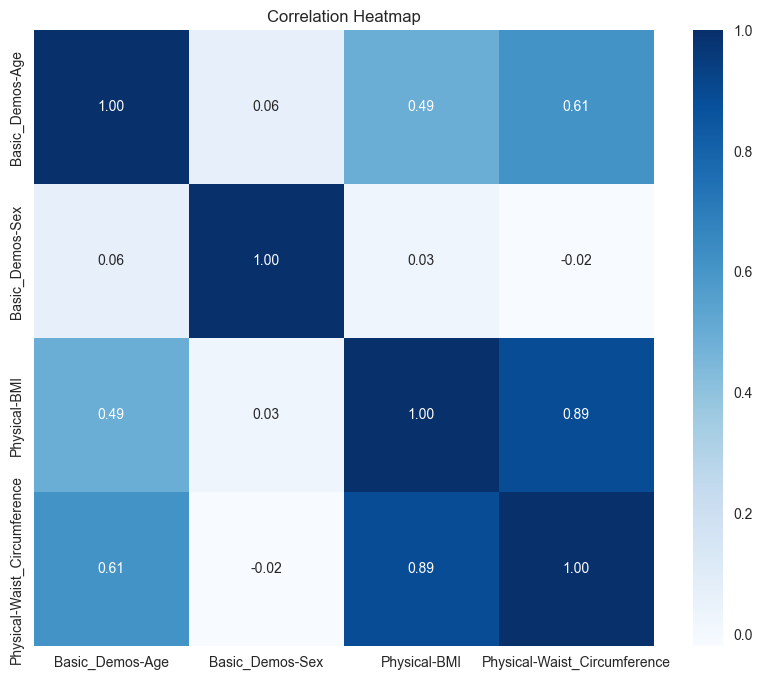

In [316]:
# train_df[['BIA-BIA_FFM','BIA-BIA_SMM']].corr()
columns_to_exclude = train_df.columns[train_df.columns.str.contains('PCIAT-PCIAT', case=False)]
df_excluded = train_df.drop(columns=columns_to_exclude, axis=1)


correlation_matrix = df_excluded.select_dtypes(include=['float64','int64'])[['Basic_Demos-Age','Basic_Demos-Sex','Physical-BMI','Physical-Waist_Circumference']].corr()
correlation_matrix

# df_excluded = df_excluded[['Basic_Demos-Age','Basic_Demos-Sex','CGAS-CGAS_Score','Physical-BMI']]
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='Blues', cbar=True)
plt.title("Correlation Heatmap")
plt.show()
